In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, classification_report
import time
#import pydotplus

## Predict Default Probability of Recent Loans
We want to try different models to predict loans that have expired

In [161]:
df1 = pd.read_excel('2007_2011.xlsx',sheetname='Sheet1')
df2 = pd.read_excel('2012_2013.xlsx',sheetname='Sheet1')
df3 = pd.read_excel('2014.xlsx',sheetname='Sheet1')
df4 = pd.read_excel('2015.xlsx',sheetname='Sheet1')
df5 = pd.read_excel('2016_Q1.xlsx',sheetname='Sheet1')
df6 = pd.read_excel('2016_Q2.xlsx',sheetname='Sheet1')
df7 = pd.read_excel('2016_Q3.xlsx',sheetname='Sheet1')

In [162]:
date_before_36 = datetime.date(2014,7,1)
date_before_60 = datetime.date(2012,7,1)
date_since_2009 = datetime.date(2010,1,1)
df1 = df1[df1.issue_d > date_since_2009]
#df2 = df2[((df2.term.str.contains('60')) & (df2.issue_d < date_before_60)) | (df2.term.str.contains('36'))]
#df3 = df3[(df3.term.str.contains('36')) & (df3.issue_d < date_before_36)]

In [5]:
#date_before_36 = datetime.date(2014,10,1)
#date_before_60 = datetime.date(2012,10,1)
#df1 = df1[((df1.term.str.contains('36')) & (df1.issue_d > date_before_36))
#                | (df1.term.str.contains('60'))]

In [163]:
data = pd.concat([df1,df2,df3,df4,df5,df6,df7],join='inner')

data = data[['id','loan_amnt','funded_amnt','funded_amnt_inv','term','int_rate',
         'installment','grade','sub_grade','emp_title','emp_length',
         'home_ownership','annual_inc','verification_status','issue_d',
         'loan_status','purpose','title','zip_code','addr_state','dti',
        'delinq_2yrs','earliest_cr_line','open_acc','pub_rec','last_pymnt_d',
        'last_pymnt_amnt','last_fico_range_high','last_fico_range_low','application_type',
             'revol_bal','revol_util']]

data.dropna(subset=['annual_inc','loan_status','issue_d','last_pymnt_d','loan_amnt',
                          'int_rate','earliest_cr_line','open_acc','pub_rec','delinq_2yrs',
                          'grade','last_fico_range_high','last_fico_range_low','installment',
                         'funded_amnt','dti','funded_amnt_inv','revol_bal']
            ,inplace=True)

print(data.shape)

(1208279, 32)


In [164]:
np.sum(data.funded_amnt_inv < data.loan_amnt) / data.shape[0]

0.089125111004991403

In [165]:
np.mean(data.dti)

18.3844394382416

## Feature Extraction
Now we want to use the following set of features for prediction model.
loan_amnt, funded amnt (investor), term (category), int_rate, installment, grade (category), emp_length (category), home_ownership (category), annual_inc, verification_status (category), purpose (category), dti, delinq_2yrs, earliest_cr_line (up to issue_d), open_acc, pub_rec, fico_high, fico_low

In [166]:
# create labels for the dataset
data['label'] = (data.loan_status.str.contains('Charged Off') | 
                data.loan_status.str.contains('Default') | 
                data.loan_status.str.contains('Late'))
data['cr_hist'] = (data.issue_d - data.earliest_cr_line) / np.timedelta64(1, 'M')
data.label = data.label.astype(int)


# clean and get training/testing data 
temp = pd.get_dummies(data[['term','grade','emp_length','home_ownership',
                                  'verification_status','purpose']],dummy_na=True)
X = data.as_matrix(columns=['loan_amnt','funded_amnt_inv','int_rate','installment',
                                       'annual_inc','dti','delinq_2yrs','open_acc','pub_rec',
                                       'last_fico_range_high','last_fico_range_low','cr_hist'])
X = np.concatenate((X,temp.as_matrix()),axis=1)
y = data.label.as_matrix()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=24)
print(X_train.shape)
print(X_test.shape)

(966623, 62)
(241656, 62)


In [146]:
np.sum(data.label)/data.shape[0]

0.130646000018246

In [157]:
print(np.sum(y_train)/y_train.shape[0])
print(np.sum(y_test)/y_test.shape[0])

0.130619226822
0.130753090362


In [168]:
from sklearn import preprocessing

min_max_scaler = preprocessing.MinMaxScaler()
X_train_minmax = min_max_scaler.fit_transform(X_train)
X_test_minmax = min_max_scaler.transform(X_test)

## Prediction of Default
### Logistic Regression with cross-validation

In [175]:
from sklearn.linear_model import LogisticRegressionCV

logisticModel = LogisticRegressionCV(cv=10)
logisticModel.fit(X_train_minmax,y_train)

LogisticRegressionCV(Cs=10, class_weight=None, cv=10, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
           refit=True, scoring=None, solver='lbfgs', tol=0.0001, verbose=0)

In [177]:
np.argsort(logisticModel.coef_)

array([[ 9,  4,  1,  6, 36,  2, 47, 52, 53, 56, 48, 51, 49, 31, 35, 22, 42,
        61, 14, 46, 59, 24, 55, 28, 32, 27, 60, 30, 29, 25, 54, 37, 26, 16,
        17, 23, 40, 33, 18, 15, 39, 41, 19, 21, 12, 57, 20, 43, 44, 45, 58,
        34, 10, 50, 13, 38, 11,  7,  8,  3,  0,  5]])

In [33]:
print(logisticModel.coef_[0,6])
print(logisticModel.coef_[0,8])

-3.84946890517
3.12741998481


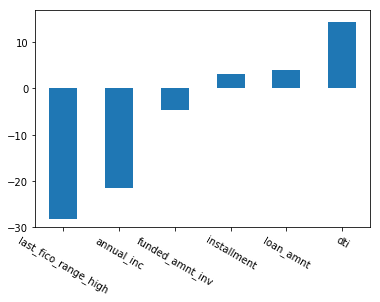

In [182]:
bplot = pd.Series(logisticModel.coef_[0,[9,4,1,3,0,5]])
xticks = ['last_fico_range_high','annual_inc','funded_amnt_inv','installment','loan_amnt','dti']
p1 = bplot.plot(kind='bar',rot=-30,ylim=(-30,17))
p1.set_xticklabels(xticks)
plt.show()

In [176]:
y_pred = logisticModel.predict(X_test_minmax)
print('accuracy: ',accuracy_score(y_test,y_pred))
target_names = ['Non-Defaulted Loan','Defaulted Loan']
print(classification_report(y_test,y_pred,target_names=target_names,digits=4))
print('AUC: ',roc_auc_score(y_test,y_pred))

accuracy:  0.917258416923
                    precision    recall  f1-score   support

Non-Defaulted Loan     0.9401    0.9649    0.9524    207198
    Defaulted Loan     0.7494    0.6306    0.6849     34458

       avg / total     0.9129    0.9173    0.9142    241656

AUC:  0.797762930132


### Support Vector Machine

In [10]:
from sklearn.svm import SVC
svcModel = SVC(kernel='rbf')
svcModel.fit(X_train_minmax,y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [11]:
y_pred = svcModel.predict(X_test_minmax)
print('accuracy: ',accuracy_score(y_test,y_pred))
target_names = ['Non-Defaulted Loan','Defaulted Loan']
print(classification_report(y_test,y_pred,target_names=target_names,digits=4))
print('AUC: ',roc_auc_score(y_test,y_pred))

accuracy:  0.941154532234
                    precision    recall  f1-score   support

Non-Defaulted Loan     0.9582    0.9763    0.9671    306878
    Defaulted Loan     0.7808    0.6649    0.7182     39011

       avg / total     0.9382    0.9412    0.9391    345889

AUC:  0.820570487016


### Random Forest

In [169]:
from sklearn.ensemble import RandomForestClassifier

time_start = time.clock()
rf_Gini = RandomForestClassifier(max_depth=10,random_state=0)
rf_Gini.fit(X_train_minmax,y_train)
time_elapsed = (time.clock() - time_start)
print('computation time: ', time_elapsed)

computation time:  28.437481999999818


In [170]:
y_pred = rf_Gini.predict(X_test_minmax)
print('accuracy: ',accuracy_score(y_test,y_pred))
target_names = ['Non-Defaulted Loan','Defaulted Loan']
print(classification_report(y_test,y_pred,target_names=target_names,digits=4))
print('AUC: ',roc_auc_score(y_test,y_pred))

accuracy:  0.917337041083
                    precision    recall  f1-score   support

Non-Defaulted Loan     0.9459    0.9584    0.9521    207198
    Defaulted Loan     0.7284    0.6702    0.6981     34458

       avg / total     0.9149    0.9173    0.9159    241656

AUC:  0.814321550507


In [174]:
rf_Entro = RandomForestClassifier(criterion='entropy',random_state=0,max_depth=10)
rf_Entro.fit(X_train,y_train)
y_pred = rf_Entro.predict(X_test)
print('accuracy: ',accuracy_score(y_test,y_pred))
target_names = ['Non-Defaulted Loan','Defaulted Loan']
print(classification_report(y_test,y_pred,target_names=target_names,digits=4))
print('AUC: ',roc_auc_score(y_test,y_pred))

accuracy:  0.916811500646
                    precision    recall  f1-score   support

Non-Defaulted Loan     0.9442    0.9597    0.9519    207198
    Defaulted Loan     0.7310    0.6592    0.6932     34458

       avg / total     0.9138    0.9168    0.9150    241656

AUC:  0.809430215881


### Decision Trees

In [171]:
from sklearn.tree import DecisionTreeClassifier

tree_Gini = DecisionTreeClassifier(max_depth=8)
time_start = time.clock()
tree_Gini.fit(X_train_minmax,y_train)
time_elapsed = (time.clock() - time_start)
print('computation time: ', time_elapsed)
y_pred = tree_Gini.predict(X_test_minmax)
print('accuracy: ',accuracy_score(y_test,y_pred))
target_names = ['Non-Defaulted Loan','Defaulted Loan']
print(classification_report(y_test,y_pred,target_names=target_names,digits=4))
print('AUC: ',roc_auc_score(y_test,y_pred))

computation time:  16.211251000000175
accuracy:  0.917150825967
                    precision    recall  f1-score   support

Non-Defaulted Loan     0.9449    0.9594    0.9521    207198
    Defaulted Loan     0.7308    0.6633    0.6954     34458

       avg / total     0.9143    0.9172    0.9155    241656

AUC:  0.811345906263


In [172]:
tree_Entro = DecisionTreeClassifier(max_depth=8,criterion='entropy')
tree_Entro.fit(X_train_minmax,y_train)
y_pred = tree_Gini.predict(X_test_minmax)
print('accuracy: ',accuracy_score(y_test,y_pred))
target_names = ['Non-Defaulted Loan','Defaulted Loan']
print(classification_report(y_test,y_pred,target_names=target_names,digits=4))
print('AUC: ',roc_auc_score(y_test,y_pred))

accuracy:  0.917150825967
                    precision    recall  f1-score   support

Non-Defaulted Loan     0.9449    0.9594    0.9521    207198
    Defaulted Loan     0.7308    0.6633    0.6954     34458

       avg / total     0.9143    0.9172    0.9155    241656

AUC:  0.811345906263


### Naive Bayes

In [183]:
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB

gnb = GaussianNB()
time_start = time.clock()
y_pred = gnb.fit(X_train_minmax,y_train).predict(X_test_minmax)
time_elapsed = (time.clock() - time_start)
print('computation time: ', time_elapsed)
print('accuracy: ',accuracy_score(y_test,y_pred))
target_names = ['Non-Defaulted Loan','Defaulted Loan']
print(classification_report(y_test,y_pred,target_names=target_names,digits=4))
print('AUC: ',roc_auc_score(y_test,y_pred))

computation time:  1.6990349999996397
accuracy:  0.775321117622
                    precision    recall  f1-score   support

Non-Defaulted Loan     0.9710    0.7606    0.8531    207198
    Defaulted Loan     0.3750    0.8636    0.5229     34458

       avg / total     0.8861    0.7753    0.8060    241656

AUC:  0.812132921141


In [184]:
mnb = MultinomialNB()
y_pred = mnb.fit(X_train_minmax,y_train).predict(X_test_minmax)
print('accuracy: ',accuracy_score(y_test,y_pred))
target_names = ['Non-Defaulted Loan','Defaulted Loan']
print(classification_report(y_test,y_pred,target_names=target_names,digits=4))
print('AUC: ',roc_auc_score(y_test,y_pred))

accuracy:  0.854181150065
                    precision    recall  f1-score   support

Non-Defaulted Loan     0.8637    0.9854    0.9206    207198
    Defaulted Loan     0.4258    0.0649    0.1127     34458

       avg / total     0.8013    0.8542    0.8054    241656

AUC:  0.525179330461


In [185]:
bnb = BernoulliNB()
y_pred = bnb.fit(X_train_minmax,y_train).predict(X_test_minmax)
print('accuracy: ',accuracy_score(y_test,y_pred))
target_names = ['Non-Defaulted Loan','Defaulted Loan']
print(classification_report(y_test,y_pred,target_names=target_names,digits=4))
print('AUC: ',roc_auc_score(y_test,y_pred))

accuracy:  0.847833283676
                    precision    recall  f1-score   support

Non-Defaulted Loan     0.8786    0.9544    0.9149    207198
    Defaulted Loan     0.4303    0.2072    0.2797     34458

       avg / total     0.8147    0.8478    0.8244    241656

AUC:  0.580802558443


## Prediction of Early Repayment

In [57]:
from statsmodels.regression.linear_model import OLS

data['duration'] = (data.last_pymnt_d - data.issue_d) / np.timedelta64(1, 'M')
data_early = data[data.loan_status.str.contains('Paid')]
print(data_early.shape)

(298184, 35)


In [58]:
y_early = data_early.duration
X_early = np.ones((data_early.shape[0],2))
X_early[:,1] = data_early.int_rate
model = OLS(y_early,X_early)
ols_result = model.fit()
print(ols_result.summary())

                            OLS Regression Results                            
Dep. Variable:               duration   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     1936.
Date:                Mon, 04 Dec 2017   Prob (F-statistic):               0.00
Time:                        00:44:38   Log-Likelihood:            -1.0649e+06
No. Observations:              298184   AIC:                         2.130e+06
Df Residuals:                  298182   BIC:                         2.130e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const         15.3776      0.046    332.070      0.0

In [63]:
X_early_2 = np.ones((data_early.shape[0],5))
X_early_2[:,1] = data_early.int_rate
X_early_2[:,2] = data_early.term.str.contains('36')
X_early_2[:,3] = data_early.last_fico_range_high
X_early_2[:,4] = data_early.loan_amnt
X_early_2 = min_max_scaler.fit_transform(X_early_2)
X_early_2[:,0] = 1
model = OLS(y_early,X_early_2)
ols_result = model.fit()
print(ols_result.summary())

                            OLS Regression Results                            
Dep. Variable:               duration   R-squared:                       0.031
Model:                            OLS   Adj. R-squared:                  0.031
Method:                 Least Squares   F-statistic:                     2408.
Date:                Mon, 04 Dec 2017   Prob (F-statistic):               0.00
Time:                        01:01:42   Log-Likelihood:            -1.0612e+06
No. Observations:              298184   AIC:                         2.122e+06
Df Residuals:                  298179   BIC:                         2.122e+06
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const         15.2554      0.246     62.091      0.0